In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn import tree, linear_model, svm, neighbors, naive_bayes, neural_network, ensemble, gaussian_process, discriminant_analysis
from sklearn.metrics import f1_score, make_scorer, confusion_matrix, auc, precision_recall_curve

### Exploratory Data Analysis

In [23]:
training = pd.read_csv('training.csv')
test = pd.read_csv('test.csv')
training.isnull().values.any()

False

There are no missing values in the training set.

In [24]:
training.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0


### Feature Definitions
| Feature Name          | Definition                                                                                                        |
|----------------------|-------------------------------------------------------------------------------------------------------------------|
| TransactionId        | Unique transaction identifier on platform                                                                      |
| BatchId              | Unique number assigned to a batch of transactions for processing                                                  |
| AccountId            | Unique number identifying the customer on platform                                                                |
| SubscriptionId       | Unique number identifying the customer subscription                                                               |
| CustomerId           | Unique identifier attached to Account                                                                             |
| CurrencyCode         | Country currency                                                                                                  |
| CountryCode          | Numerical geographical code of country                                                                            |
| ProviderId           | Source provider of Item ÔøΩbought.                                                                                |
| ProductId            | Item name being bought.                                                                                           |
| ProductCategory      | ProductIds are organized into these broader product categories.                                                   |
| ChannelId            | Identifies if customer used web,Android, IOS, pay later or checkout.                                              |
| Amount               | Value of the transaction. Positive for debits from customer account and negative for credit into customer account |
| Value                | Absolute value of the amount                                                                                      |
| TransactionStartTime | Transaction start time                                                                                            |
| PricingStrategy      | Category of Xente's pricing structure for merchants                                                               |
| FraudResult          | Fraud status of transaction 1 -yes or 0-No                                                                        |

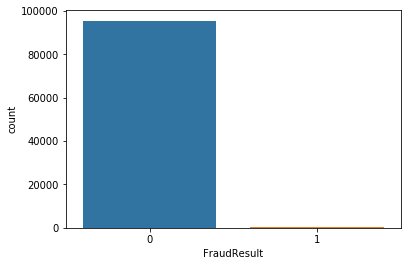

In [28]:
sns.countplot("FraudResult", data=training)
plt.show()

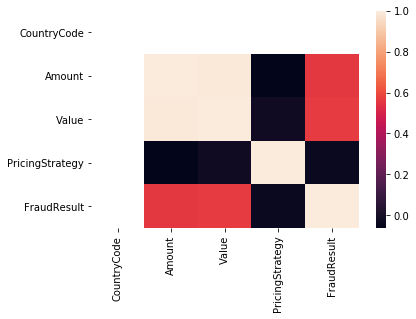

In [30]:
sns.heatmap(training.corr())
plt.show()

Currently only 4 numerical variables can be correlated. The only variables with correlation are Value and Amount, because Amount is the modulus of Value.

### Feature Engineering
Features added:
- One-hot encoded features for all categorical variables
- Withdrawal / deposit boolean
- Difference in transaction value with previous transaction made by same account (first transactions filled with mean value)
- Time since previous transaction made by same account (first transactions filled with mean value)
- Difference between transaction amount/value and average account amount/value
	- stratified by Category
	- stratified by Provider
	- stratified by Product
	- Stratified by Channel
- Difference from average account transaction time (hour)
- Total account transactions in same hour
- Decomposition of DateTime feature (Hour, Day of week, Day)
- Difference from average overall transaction time
	- stratified by Category / Provider / Product / Channel

In [2]:
def add_features(df):

    # Store index
    idx = df.index

    df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime'])

    for col in ('ProviderId', 'ProductId', 'ProductCategory', 'ChannelId', 'PricingStrategy'):
        for_dummy = df[col]
        df = pd.concat([df, pd.get_dummies(for_dummy, prefix=col)], axis=1)

    # Withdrawal or deposit

    df['Withdrawal'] = (df['Amount'] > 0) * 1
    df['Simple'] = (df['Value'] > 495000) * 1

    # Difference with previous transaction amount

    df = df.sort_values(['AccountId', 'TransactionStartTime'], ascending=True)

    df['Difference from previous transaction'] = df['Value'].diff()
    mask = df['AccountId'] != df['AccountId'].shift(1)
    df['Difference from previous transaction'][mask] = np.nan
    df['Difference from previous transaction'] = df['Difference from previous transaction'].fillna(
        df['Difference from previous transaction'].mean())

    # Difference with previous transaction time

    df['Time difference from previous transaction'] = df['TransactionStartTime'].diff()
    mask = df['AccountId'] != df['AccountId'].shift(1)
    df['Time difference from previous transaction'][mask] = np.nan
    df['Time difference from previous transaction'] = df['Time difference from previous transaction'].fillna(
        df['Time difference from previous transaction'].mean())

    df['DateNum'] = pd.to_numeric(
        df['Time difference from previous transaction'])

    # Difference from average account transaction

  #  df['Difference from Average Account'] = df.groupby(
  #      'AccountId')['Value'].transform(lambda x: (x - x.mean()))

    # Difference from average account transaction by ProductCategory / ProviderId / ProductId

  #  df['CategoryDiffV'] = df.groupby(['AccountId', 'ProductCategory'])[
  #      'Value'].transform(lambda x: (x - x.mean()))
  #  df['CategoryDiffA'] = df.groupby(['AccountId', 'ProductCategory'])[
  #      'Amount'].transform(lambda x: (x - x.mean()))
  # df['ProviderDiffV'] = df.groupby(['AccountId', 'ProviderId'])[
  #      'Value'].transform(lambda x: (x - x.mean()))
  #  df['ProviderDiffA'] = df.groupby(['AccountId', 'ProviderId'])[
  #      'Amount'].transform(lambda x: (x - x.mean()))
  #  df['ProductDiffV'] = df.groupby(['AccountId', 'ProductId'])[
  #      'Value'].transform(lambda x: (x - x.mean()))
  #  df['ProductDiffA'] = df.groupby(['AccountId', 'ProductId'])[
  #      'Amount'].transform(lambda x: (x - x.mean()))
  #  df['ChannelDiffA'] = df.groupby(['AccountId', 'ChannelId'])[
  #      'Amount'].transform(lambda x: (x - x.mean()))
  #  df['ChannelDiffV'] = df.groupby(['AccountId', 'ChannelId'])[
  #      'Value'].transform(lambda x: (x - x.mean()))

    # Difference from average account hour
    df['Hour'] = df['TransactionStartTime'].dt.hour
    df['Day'] = df['TransactionStartTime'].dt.dayofyear
    df['Transactions in same hour'] = df.groupby(['AccountId', 'Day', 'Hour'])[
        'Amount'].transform('count')
    df['DayofWeek'] = df['TransactionStartTime'].dt.weekday
    df['Difference from Average Time'] = df.groupby(
        'AccountId')['Hour'].transform(lambda x: (x - x.mean()))

    # Overall averages
 #   df['Difference from Average Time Overall'] = df['Hour'].transform(lambda x: (x - x.mean()))
 #   df['CategoryDiffOverallV'] = df.groupby(['ProductCategory'])['Value'].transform(lambda x: (x - x.mean()))
 #   df['CategoryDiffOverallA'] = df.groupby(['ProductCategory'])[
 #       'Amount'].transform(lambda x: (x - x.mean()))
 #   df['ProviderDiffOverallV'] = df.groupby(
 #       ['ProviderId'])['Value'].transform(lambda x: (x - x.mean()))
 #   df['ProviderDiffOverallA'] = df.groupby(
 #       ['ProviderId'])['Amount'].transform(lambda x: (x - x.mean()))
 #   df['ProductDiffOverallV'] = df.groupby(
 #       ['ProviderId'])['Value'].transform(lambda x: (x - x.mean()))
 #   df['ProductDiffOverallA'] = df.groupby(
 #       ['ProviderId'])['Amount'].transform(lambda x: (x - x.mean()))

    df = df.reindex(idx)

    return df

training = add_features(training)
test = add_features(test)

/Users/tom/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/tom/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Further Visualisation

KeyError: 'Time'

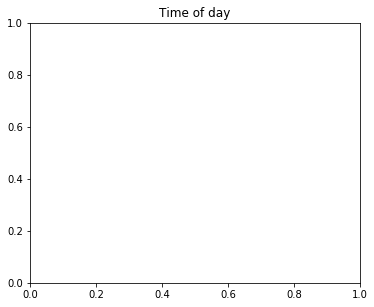

In [32]:
fraud = training[training['FraudResult'] == 1]
genuine = training[training['FraudResult'] == 0]

fig = plt.figure(figsize=(13,22))

plt.subplot(421)
plt.title('Time of day')
plt.hist(fraud['Time'], density=True, alpha=0.5)
plt.hist(genuine['Time'], density=True, alpha=0.5)
plt.xlabel('Minutes past midnight')
plt.legend(['Fraud', 'Genuine'])

plt.subplot(422)
plt.title('Value')
plt.hist(fraud['Value'], density=True, alpha=0.5)
plt.hist(genuine['Value'], density=True, alpha=0.5)
plt.xlabel('UGX')
plt.legend(['Fraud', 'Genuine'])

plt.subplot(423)
plt.title('Amount')
plt.hist(fraud['Amount'], density=True, alpha=0.5)
plt.hist(genuine['Amount'], density=True, alpha=0.5)
plt.xlabel('UGX')
plt.legend(['Fraud', 'Genuine'])

plt.subplot(424)
plt.title('Difference from account average transaction')
plt.hist(fraud['Difference from Average Account'], density=True, alpha=0.5)
plt.hist(genuine['Difference from Average Account'], density=True, alpha=0.5)
plt.xlabel('UGX')
plt.legend(['Fraud', 'Genuine'])

ax1 = fig.add_subplot(425)
data = training.groupby('FraudResult')['ChannelId'].value_counts(normalize=True).unstack()
data.plot(kind='barh', ax=ax1)
plt.title('ChannelId')
plt.xlabel('Density')

ax2 = fig.add_subplot(426)
data = training.groupby('FraudResult')['DayofWeek'].value_counts(normalize=True).unstack()
data.plot(kind='barh', ax=ax2)
plt.title('Day of week')
plt.xlabel('Density')

ax3 = fig.add_subplot(427)
data = training.groupby('FraudResult')['ProductCategory'].value_counts(normalize=True).unstack()
data.plot(kind='barh', ax=ax3)
plt.title('Product Category')
plt.xlabel('Density')

ax3 = fig.add_subplot(428)
data = training.groupby('FraudResult')['ProviderId'].value_counts(normalize=True).unstack()
data.plot(kind='barh', ax=ax3)
plt.title('ProviderId')
plt.xlabel('Density')



plt.show()

### Data preparation
- Some categorical values present in test set but not in training set and vice versa, leading to a mismatch in the number of columns. The missing columns were added to both datasets, being careful to then reorder columns to match between the two.
- Feature scaling necessary for non-decision tree based classifiers
- Columns with non-numerical values unsuitable for input to classifier removed
- Dataframes converted to numpy array for classifier input

In [3]:
# Add features in test but not training set
for col in list(set(test.columns) - set(training.columns)):
    training[col] = 0

# Add features in training but not test set
for col in list(set(training.columns) - set(test.columns)):
    test[col] = 0

X = training.drop(['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId', 'CurrencyCode',
                   'CountryCode', 'ProviderId', 'ProductId', 'ProductCategory', 'ChannelId', 'TransactionStartTime',
                   'FraudResult', 'Time difference from previous transaction'], axis=1)

X_test = test.drop(['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId', 'CurrencyCode',
                    'CountryCode', 'ProviderId', 'ProductId', 'ProductCategory', 'ChannelId', 'TransactionStartTime',
                    'FraudResult', 'Time difference from previous transaction'], axis=1)

# Match column order between training and test sets
X_test = X_test[X.columns]

features = X.columns

X = X.values
#X = StandardScaler().fit_transform(X)
X_test = X_test.values
#X_test = StandardScaler().fit_transform(X_test)
y = training['FraudResult'].values

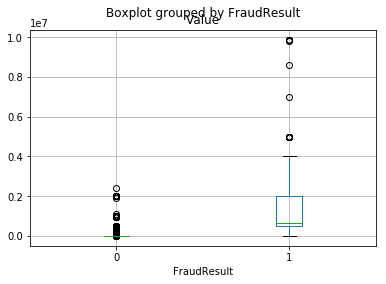

In [4]:
training.boxplot(column=['Value'], by='FraudResult')
plt.show()

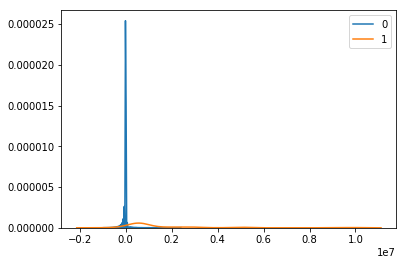

In [5]:
for x in [0,1]:
    sns.kdeplot(training[training['FraudResult'] == x]['Amount'])
plt.legend(('0','1'))
plt.show()

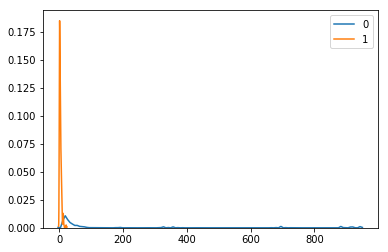

In [6]:
for x in [0,1]:
    sns.kdeplot(training[training['FraudResult'] == x]['Transactions in same hour'])
plt.legend(('0','1'))
plt.show()

In [21]:
# Isolate features

training['Simple'] = (training['Amount'] > 499000)*1
X = training[['Simple','Difference from previous transaction']].values
features = ['Simple','Difference from previous transaction']

### Exploratory Data Analysis
- Used F1 scoring as this is the metric on which the competition solutions are ranked
- K fold cross validation with a mean cross validated score and mean confusion matrix
- Compared a range of classifiers from Scikit-learn, most of which performed poorly (Naive bayes, SVM, Logistic Regression)
- Decision trees performed best, with no significant improvement in performance from Random Forest ensembles

In [8]:
def f1_scorer(clf, X, y):

    y_pred = clf.predict(X)

    return f1_score(y, y_pred)

def cross_validation_score_f1(clf, X, y, cv):

    cv_score = 0
    train_score = 0
    val_score = 0
    cm = np.zeros([2,2])

    skf = StratifiedKFold(n_splits=cv, random_state=1, shuffle=False)

    for train_index, val_index in skf.split(X, y):

        
        clf.fit(X[train_index], y[train_index])

        train_score = f1_scorer(clf, X[train_index], y[train_index])
        val_score = f1_scorer(clf, X[val_index], y[val_index])

        print("Train F1: {} Test F1: {}".format(train_score, val_score))

        cv_score += val_score
        
        y_pred = clf.predict(X[val_index])
        cm += confusion_matrix(y[val_index], y_pred)
        
    print('Mean confusion matrix:')
    print(np.round(cm/cv, 1))

    return cv_score / cv

In [9]:
clf = naive_bayes.BernoulliNB()
print("Random Forest")
score = cross_validation_score_f1(clf, X, y, 8)
print("Cross-validated F1 score: {}".format(score))

Random Forest
Train F1: 0.7835616438356163 Test F1: 0.9433962264150945
Train F1: 0.7977839335180057 Test F1: 0.8421052631578948
Train F1: 0.7999999999999999 Test F1: 0.8275862068965517
Train F1: 0.7956989247311829 Test F1: 0.8695652173913043
Train F1: 0.8390501319261213 Test F1: 0.4615384615384615
Train F1: 0.8264462809917356 Test F1: 0.6545454545454547
Train F1: 0.7933884297520661 Test F1: 0.8727272727272727
Train F1: 0.7933884297520661 Test F1: 0.8727272727272727
Mean confusion matrix:
[[1.19265e+04 7.10000e+00]
 [3.10000e+00 2.10000e+01]]
Cross-validated F1 score: 0.7930239219249134


In [10]:
dtc = tree.DecisionTreeClassifier(criterion='entropy', max_depth=2)
print("Decision Tree")
score = cross_validation_score_f1(dtc, X, y, 8)
print("Cross-validated F1 score: {}".format(score))

Decision Tree
Train F1: 0.7835616438356163 Test F1: 0.9433962264150945
Train F1: 0.7977839335180057 Test F1: 0.8421052631578948
Train F1: 0.7999999999999999 Test F1: 0.8275862068965517
Train F1: 0.7956989247311829 Test F1: 0.8695652173913043
Train F1: 0.8390501319261213 Test F1: 0.4615384615384615
Train F1: 0.8264462809917356 Test F1: 0.6545454545454547
Train F1: 0.7933884297520661 Test F1: 0.8727272727272727
Train F1: 0.7933884297520661 Test F1: 0.8727272727272727
Mean confusion matrix:
[[1.19265e+04 7.10000e+00]
 [3.10000e+00 2.10000e+01]]
Cross-validated F1 score: 0.7930239219249134


In [11]:
rf = ensemble.RandomForestClassifier(max_depth=3)
print("Random Forest")
score = cross_validation_score_f1(rf, X, y, 8)
print("Cross-validated F1 score: {}".format(score))

Random Forest


/Users/tom/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Train F1: 0.8055555555555555 Test F1: 0.9433962264150945
Train F1: 0.8022284122562675 Test F1: 0.8421052631578948
Train F1: 0.8068181818181818 Test F1: 0.8421052631578948
Train F1: 0.8 Test F1: 0.8695652173913043
Train F1: 0.8421052631578947 Test F1: 0.4615384615384615
Train F1: 0.8362573099415205 Test F1: 0.64
Train F1: 0.8033240997229917 Test F1: 0.7692307692307692
Train F1: 0.6666666666666667 Test F1: 0.4736842105263159
Mean confusion matrix:
[[1.19271e+04 6.50000e+00]
 [5.80000e+00 1.84000e+01]]
Cross-validated F1 score: 0.7302031764272169


### Feature Importances
- Noticed a strong preference towards *Value*, *Amount* features
- Huge performance drop (models appear to have no predictive power) when these features and all those derived from them are removed
- Seems unlikely that fraudulent transactions could be identified purely based on their amount. This lead me to investigate by trimming the decision trees and examining the result.

In [12]:
dtc.fit(X, y)
rf.fit(X, y)

for x, y2, z in zip(features, dtc.feature_importances_, rf.feature_importances_):
    print(x, y2, z)

Amount 0.9670986002945237 0.6259336903153538
Value 0.03290139970547622 0.37406630968464605


### Trimmed decision tree

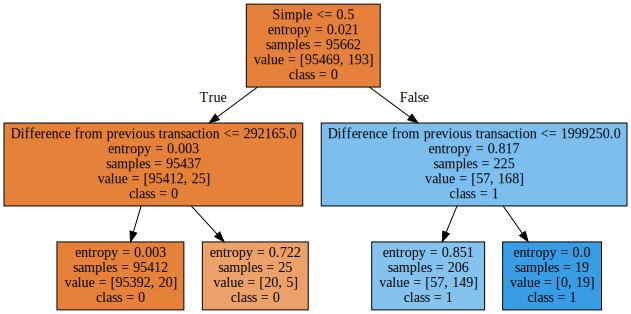

In [22]:
graph = Source(tree.export_graphviz(dtc, out_file=None
   , feature_names=features, class_names=['0', '1'] 
   , filled = True))
display(SVG(graph.pipe(format='svg')))

### Output csv file for competition submission

In [ ]:
test_preds = dtc.predict(X_test)
output = pd.DataFrame()
test = pd.read_csv('test.csv')
output['TransactionId'] = test['TransactionId']
output['FraudResult'] = test_preds
output.to_csv('submission.csv', index=False)